## Processing an image of coins

Read the image of coins you have been provided and display it with an appropriate title

(400, 300, 3) uint8


(<matplotlib.image.AxesImage at 0x227e19056d0>,
 (-0.5, 299.5, 399.5, -0.5),
 Text(0.5, 1.0, 'Coin Image'))

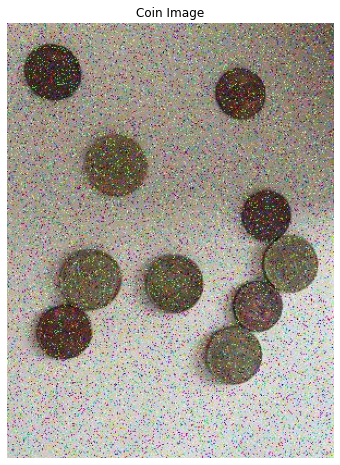

In [1]:
from skimage import io, segmentation
from skimage.exposure import histogram
import matplotlib.pyplot as plt
im = io.imread("coin_image.jpg")
print(im.shape, im.dtype)
plt.figure(figsize=(8,8))
plt.imshow(im), plt.axis('off'), plt.title('Coin Image')

Remove the salt and pepper noise in the image and display the denoised image with an appropriate title

<ipython-input-4-d65d2e418f8d>:7: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  im  =img_as_ubyte(color.rgb2gray(im))


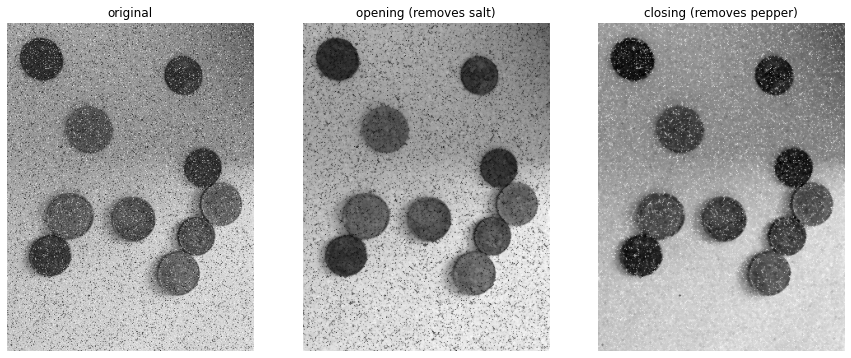

In [4]:
from skimage.morphology import binary_erosion,binary_dilation, binary_opening,binary_closing,dilation, erosion, opening, closing, white_tophat, watershed, remove_small_objects, reconstruction, extrema,disk
from skimage import img_as_ubyte, img_as_float
from skimage.filters import median 
from skimage import color

# change rgb image to gray scale
im  =img_as_ubyte(color.rgb2gray(im))
# by using opening we can remove the salt noise
im_o = opening(im, disk(1))
# by using closing we can remove the pepper noise
im_c = closing(im, disk(1))
# by using opening followed by closing we remove salt and pepper noise
im_oc = closing(im_o, disk(1))

plt.figure(figsize=(15,15))
plt.subplot(131), plt.imshow(im, cmap='gray'), plt.title('original'), plt.axis('off')
plt.subplot(132), plt.imshow(im_o, cmap='gray'), plt.title('opening (removes salt)'), plt.axis('off')
plt.subplot(133), plt.imshow(im_c, cmap='gray'), plt.title('closing (removes pepper)'),plt.axis('off')
plt.show()

Segment the coins to obtain a binary image where pixels representing the coins are set to 1

(<AxesSubplot:title={'center':'Watershed Segmentation'}>,
 (-0.5, 299.5, 399.5, -0.5),
 Text(0.5, 1.0, 'Watershed Segmentation'))

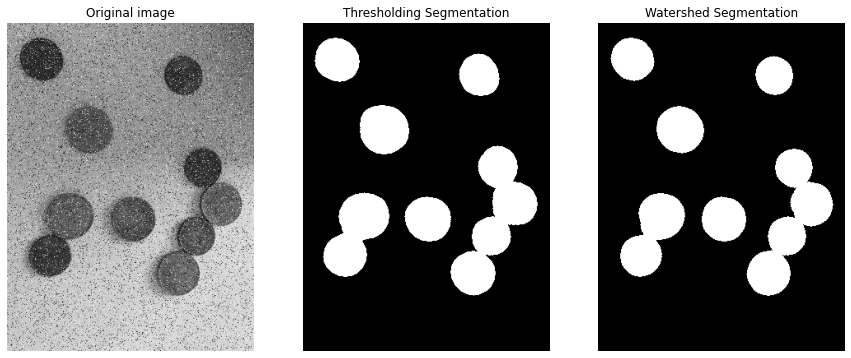

In [7]:
from skimage.transform import  hough_circle, hough_circle_peaks
from skimage import feature
from skimage.morphology import square, rectangle, diamond, disk, cube,  octahedron, ball, star, octagon 
from skimage.draw import circle_perimeter
from skimage import util
import scipy.ndimage.filters
import numpy as np
from skimage.filters import rank
from skimage import filters
from skimage.measure import label, regionprops
from scipy import ndimage as ndi
from skimage import data

# we will use thresholding segmentation
thresh = filters.threshold_otsu(im_oc)
im_th = im_oc < thresh
# perform opening to for clearing the edges
im_th_morph = binary_opening(im_th, disk(20))
# perform clear_border to remove unwanted forground
im_seg = segmentation.clear_border(im_th_morph)

# we will use watershed segmentation
# find an elevation map using the Sobel gradient of the image
elevation_map = filters.sobel(im_oc)
# find markers of the background and the coins
markers = np.zeros_like(im_oc)
markers[im_oc < 70] = 1
markers[im_oc > 150] = 2
# watershed transform to fill regions of the elevation map
segmentation_coins = segmentation.watershed(elevation_map, markers)
segmentation_coins = 1 - segmentation_coins
# perform closing to fill more gaps
seg_im = binary_closing(segmentation_coins, disk(18)) 
seg_im = 1 - seg_im
plt.figure(figsize = (15,15))
plt.subplot(131), plt.imshow(im, cmap='gray'), plt.axis('off'), plt.title("Original image")
plt.subplot(132), plt.imshow(im_seg, cmap ='gray'), plt.axis('off'), plt.title("Thresholding Segmentation")
plt.subplot(133), plt.imshow(seg_im, cmap='gray'), plt.axis('off'), plt.title("Watershed Segmentation")



Using the binary image as input, write code to output a new image containing

(a) only the coins which overlap or touch each other

(b) only non-overlapping coins

(<AxesSubplot:title={'center':'Non overlapping coins'}>,
 (-0.5, 299.5, 399.5, -0.5),
 Text(0.5, 1.0, 'Non overlapping coins'))

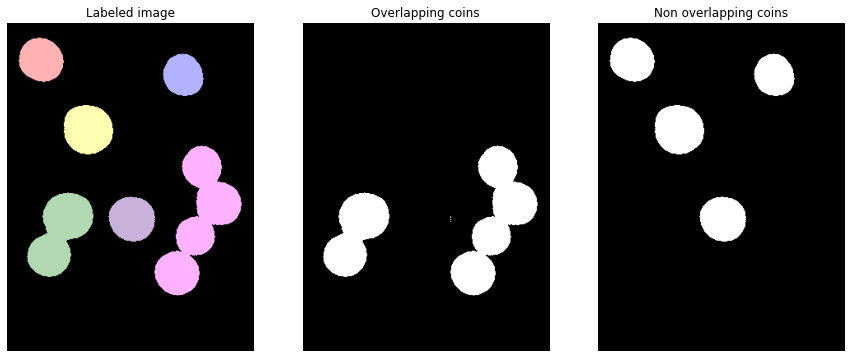

In [8]:
from skimage import measure
import matplotlib.patches as mpatches

# create 2 np zero arrays
image1 = np.zeros(im_seg.shape) 
image2 = np.zeros(im_seg.shape)

label_image = label(im_seg)
image_label = color.label2rgb(label_image, image=im_seg, bg_label=0)


for region in regionprops(label_image):
    # regions with large enough areas are the overlapping coins
    if region.area > 3000:
        minr, minc, maxr, maxc = region.bbox
        image1[minr:maxr, minc:maxc] = im_seg[minr:maxr, minc:maxc]
    else:
        minr, minc, maxr, maxc = region.bbox
        image2[minr:maxr, minc:maxc] = im_seg[minr:maxr, minc:maxc]

plt.figure(figsize=(15,10))
plt.subplot(1,3,1), plt.imshow(image_label, cmap='gray'), plt.axis('off'), plt.title('Labeled image')
plt.subplot(1,3,2), plt.imshow(image1, cmap='gray'), plt.axis('off'), plt.title('Overlapping coins')
plt.subplot(1,3,3), plt.imshow(image2, cmap='gray'), plt.axis('off'), plt.title('Non overlapping coins')

Sets of white pixels which are connected to each other are called connected components or objects.

(i) connect all the connected components and visualize each connected component with a different color overlaid on the denoised image.

(ii) separate the touching coins (visualize each coin with a different color overlaid on the denoised image).

C:\Users\RATL\anaconda3\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


Text(0.5, 1.0, 'Separated components')

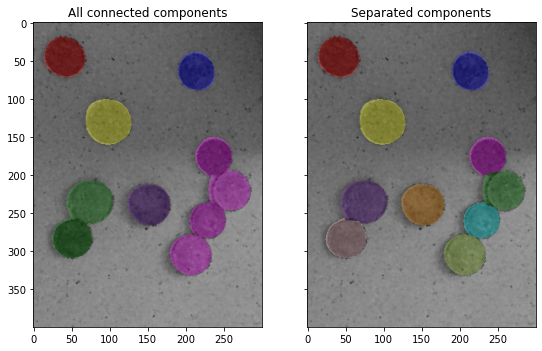

In [9]:
from scipy import ndimage as ndi
from skimage.measure import label, regionprops
from skimage.morphology import watershed
from skimage.feature import peak_local_max

# (i)
# connect the components 
image_label_overlay = color.label2rgb(label_image, image=im_oc, bg_label=0)

# (ii)
# The distance transform of a binary image is the distance from every pixel to the nearest nonzero-valued pixel.
distance = ndi.distance_transform_edt(im_seg)
# Markers are created by taking local maxima of the distance to the background
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((10, 10)), labels=im_seg)
markers = ndi.label(local_maxi)[0]
# process the watershed
labels = watershed(-distance, markers, mask=im_seg)
# connect the components 
image_label_overlay2 = color.label2rgb(labels, image=im_oc, bg_label=0)

# Display the results 
fig, axes = plt.subplots(ncols=2, figsize=(9, 8), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(image_label_overlay, cmap=plt.cm.gray)
ax[0].set_title('All connected components')
ax[1].imshow(image_label_overlay2, cmap=plt.cm.nipy_spectral)
ax[1].set_title('Separated components')

 Show your original image with an overlay of bounding boxes or circular boundaries of each coin you found. List the number of coins your code found.

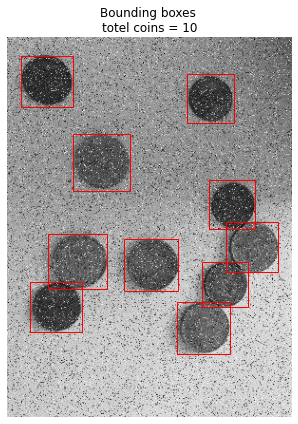

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
image3 = img_as_ubyte(im)
image3 = color.gray2rgb(image3)
regions = regionprops(labels)
mean_region_area = 0
for region in regions:
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)
        mean_region_area +=  region.area
        
mean_region_area = mean_region_area / len(regions)
ax.set_axis_off()
ax.imshow(image3)
ax.set_title("Bounding boxes \ntotel coins = "+ str(len(regions)))
plt.tight_layout()
plt.show()

The image contains 5 cents and 50 cents. Indicate the amount of money your code finds in the image. Show your original image with an overlay of green points on the centroids of 5 cents and red points on the centroids of 50 cents.

Some properties of the 1st object
Orientation: 0.915942597594871 Boundingbox: (19, 14, 73, 69) Major Axis Length: 55.72345658073362
2264.8


Text(0.5, 1.0, 'Green = 5 cents Red = 50 cents\n totel amount of money = 275cents')

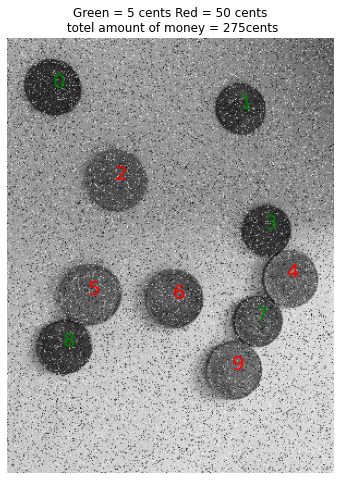

In [11]:
cents_50 = 0
cents_5 = 0

plt.figure(figsize=(8,8))
plt.imshow(image3, cmap=plt.cm.gray)

print('Some properties of the 1st object')
print('Orientation:', regions[0].orientation, 'Boundingbox:', regions[0].bbox , 'Major Axis Length:', regions[0].major_axis_length)
print(mean_region_area)

for (i, props) in zip(range(len(regions)), regions):
    # , displays the ID of each object at it's centroid.
    if (props.area > mean_region_area) :
        y0, x0 = props.centroid
        plt.text(x0, y0,i,color='r', fontsize=20)
        cents_50 += 1
    else:
        y0, x0 = props.centroid
        plt.text(x0, y0,i,color='g', fontsize=20)
        cents_5 += 1
total_amount = cents_50 *50 + cents_5 * 5
plt.axis('off')    
plt.title("Green = 5 cents Red = 50 cents\n totel amount of money = "+str(total_amount)+"cents")